# Analysis

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

## 1. Load the data

In [ ]:
file_path = 'ICTE-Watts-Full.csv'
data = pd.read_csv(file_path)

data.head(), data.columns

mapping_dict = {
    'emqx': 'EMQX',
    'hive': 'HiveMQ CE',
    'mochi': 'Mochi-MQTT',
    'nanomq': 'NanoMQ'
}

data.replace(mapping_dict, inplace=True)

## 2. Plot Graphs

In [ ]:
data_20s = data[data['Elapsed'] == 20]

In [ ]:
total_means_at_20s = data_20s.groupby('Broker').mean()[['Total Published(Messages)', 'Total Received(Messages)']]
total_means_at_20s

,Total Published(Messages),Total Received(Messages)
Broker,,
EMQX,3964.6,371094.9
HiveMQ CE,3959.6,375782.8
Mochi-MQTT,3983.7,216664.6
NanoMQ,3957.4,454560.5


### Watts, Rate(Bytes/s)

In [ ]:
broker_means = data.groupby('Broker').mean()
comparison_metrics = broker_means[['Watts', 'Publish Rate(Messages/s)', 'Receive Rate(Messages/s)']]
comparison_metrics[['Publish Rate(Messages/s)', 'Receive Rate(Messages/s)']]

,Publish Rate(Messages/s),Receive Rate(Messages/s)
Broker,,
EMQX,198.19245,18553.2553
HiveMQ CE,197.94065,18788.1243
Mochi-MQTT,199.14005,18627.7743
NanoMQ,197.83475,22646.6937


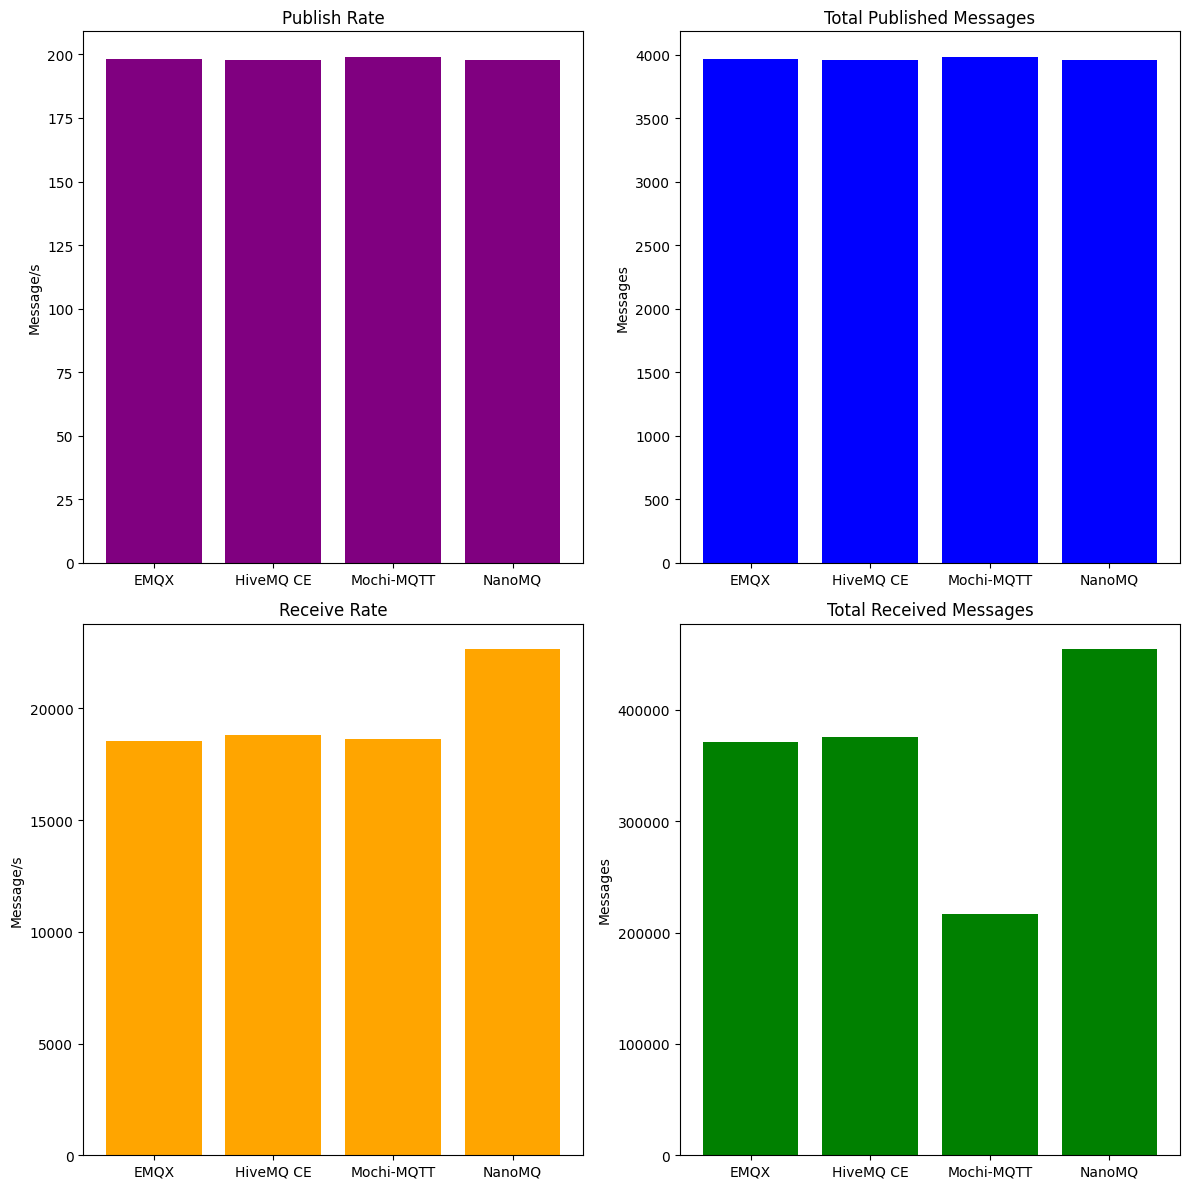

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))


ax[0, 0].bar(comparison_metrics.index, comparison_metrics['Publish Rate(Messages/s)'], color='purple')
ax[0, 0].set_title('Publish Rate')
ax[0, 0].set_ylabel('Message/s')


ax[1, 0].bar(comparison_metrics.index, comparison_metrics['Receive Rate(Messages/s)'], color='orange')
ax[1, 0].set_title('Receive Rate')
ax[1, 0].set_ylabel('Message/s')


ax[0, 1].bar(total_means_at_20s.index, total_means_at_20s['Total Published(Messages)'], color='blue')
ax[0, 1].set_title('Total Published Messages')
ax[0, 1].set_ylabel('Messages')


ax[1, 1].bar(total_means_at_20s.index, total_means_at_20s['Total Received(Messages)'], color='green')
ax[1, 1].set_title('Total Received Messages')
ax[1, 1].set_ylabel('Messages')

plt.tight_layout()
plt.show()


## Watts

In [ ]:
seconds = 20
CO2_per_kWh_UK = 0.2070

comparison_metrics_= comparison_metrics

comparison_metrics_['Energy (Joules)'] = comparison_metrics_['Watts'] * seconds

comparison_metrics_['Energy (Wh)'] = comparison_metrics_['Watts'] * (seconds / 3600)

comparison_metrics_['CO2 Emissions (g)'] = comparison_metrics_['Energy (Wh)'] * CO2_per_kWh_UK
comparison_metrics_.round()
comparison_metrics_[['Watts','Energy (Joules)', 'Energy (Wh)','CO2 Emissions (g)'] ]

<ipython-input-34-c8c3f630bc99>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_metrics_['Energy (Joules)'] = comparison_metrics_['Watts'] * seconds
<ipython-input-34-c8c3f630bc99>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_metrics_['Energy (Wh)'] = comparison_metrics_['Watts'] * (seconds / 3600)
<ipython-input-34-c8c3f630bc99>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Watts,Energy (Joules),Energy (Wh),CO2 Emissions (g)
Broker,,,,
EMQX,4.7070,94.14,0.026150,0.005413
HiveMQ CE,5.0990,101.98,0.028328,0.005864
Mochi-MQTT,4.0625,81.25,0.022569,0.004672
NanoMQ,4.0030,80.06,0.022239,0.004603


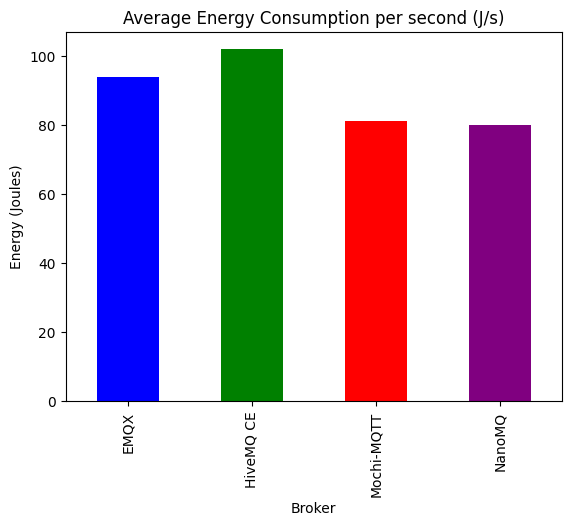

In [ ]:
fig, ax = plt.subplots()
colors = ['blue', 'green', 'red', 'purple']

comparison_metrics_['Energy (Joules)'].plot(kind='bar', ax=ax, color=colors)

# Set titles and labels
ax.set_title('Average Energy Consumption per second (J/s)')
ax.set_xlabel('Broker')
ax.set_ylabel('Energy (Joules)')

plt.show()

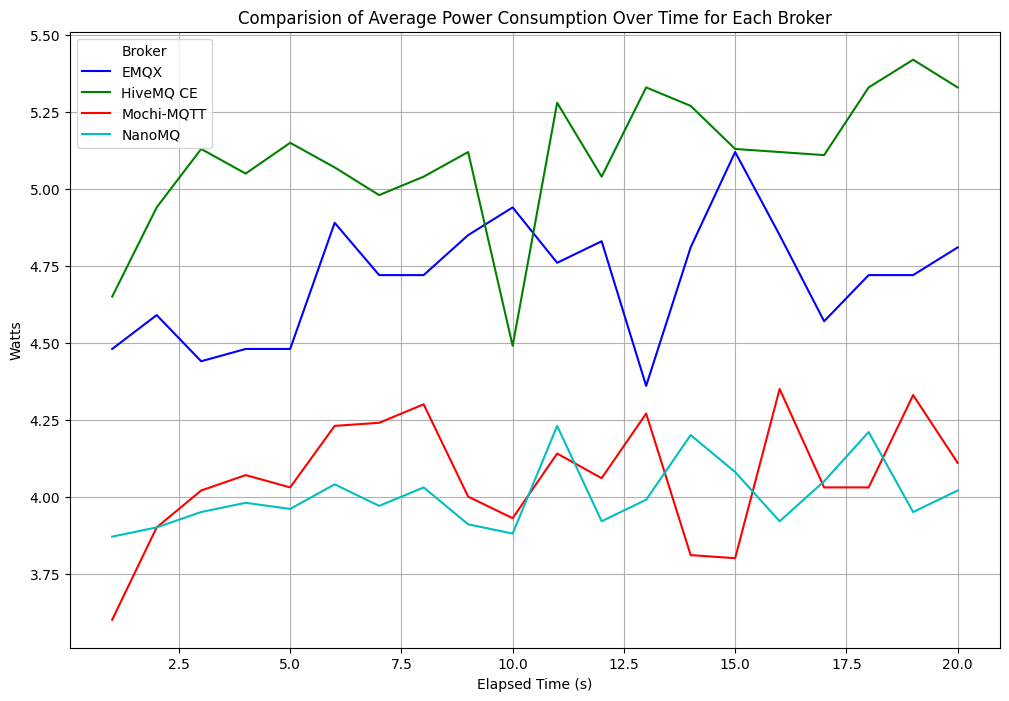

In [ ]:
timeseries_data = data[data['Elapsed'] <= 20]

average_watts = timeseries_data.groupby(['Broker', 'Elapsed'])['Watts'].mean().unstack(0)

plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for i, broker in enumerate(average_watts.columns):
    plt.plot(average_watts.index, average_watts[broker], label=broker, color=colors[i % len(colors)])

plt.title('Comparision of Average Power Consumption Over Time for Each Broker')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Watts')
plt.legend(title='Broker')
plt.grid(True)
plt.show()

# Statisical Testing

In [ ]:
alpha = 0.05

data_20s = data[data['Elapsed'] == 20]

energy_data = [group['Watts'].values * 20 for _, group in data.groupby('Broker')]
total_published = [group['Total Published(Messages)'].values for _, group in data_20s.groupby('Broker')]
total_received = [group['Total Received(Messages)'].values for _, group in data_20s.groupby('Broker')]

anova_energy = f_oneway(*energy_data)
anova_published = f_oneway(*total_published)
anova_received = f_oneway(*total_received)

def test_hypothesis(pvalue, alpha):
    print(pvalue)
    if pvalue < alpha:
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis is accepted")

print("For energy consumption:")
test_hypothesis(anova_energy.pvalue, alpha)
print("\nFor published messages:")
test_hypothesis(anova_published.pvalue, alpha)
print("\nFor received messages:")
test_hypothesis(anova_received.pvalue, alpha)


For energy consumption:
6.716162600062741e-120
The null hypothesis can be rejected

For published messages:
0.4314391285667989
The null hypothesis is accepted

For received messages:
0.0014830095626619164
The null hypothesis can be rejected
